In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
import umap
import json
import time
import io
import re

In [6]:
# read the data in from csv
data = pd.read_csv('../data/akhaliq_tweets.csv', encoding='utf-8')

In [13]:
data.shape

AttributeError: 'APIResponse' object has no attribute 'shape'

In [8]:
# data.head()

,Tweet Id,Text,Name,Screen Name,UTC,Created At,Favorites,Retweets,Language,Client,Tweet Type,URLs,Hashtags,Mentions,Media Type,Media URLs,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,1648347964836855809,RT @CerebrasSystems : *Check out Cerebras-GPT ...,AK,_akhaliq,2023-04-18T15:29:14.000Z,Tue Apr 18 15:29:14 +0000 2023,0,0,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Retweet,https://huggingface.co/cerebras https://discor...,0,0,NaN,NaN,NaN,NaN,NaN
1,1648347811115679745,RT @algo_diver : Trying to remake Alpaca-LoRA-...,AK,_akhaliq,2023-04-18T15:28:37.000Z,Tue Apr 18 15:28:37 +0000 2023,0,0,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Retweet,NaN,0,0,photo,https://pbs.twimg.com/media/FuAYR-CaIAAvtL2.jpg,NaN,NaN,NaN
2,1648334113487704064,RT @shota7180 : 画像について質問すると回答を生成する『MiniGPT-4』は...,AK,_akhaliq,2023-04-18T14:34:11.000Z,Tue Apr 18 14:34:11 +0000 2023,0,0,ja,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Retweet,https://twitter.com/i/web/status/1648259127301...,0,0,video,https://video.twimg.com/amplify_video/16482591...,NaN,NaN,NaN
3,1648328489651646465,RT @yvrjsharma : 🥁 Drumroll please... \n🏆 Cong...,AK,_akhaliq,2023-04-18T14:11:51.000Z,Tue Apr 18 14:11:51 +0000 2023,0,0,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Retweet,https://twitter.com/i/web/status/1648250456408...,0,2,photo,https://pbs.twimg.com/media/Ft_B2tPaUAYxZHB.jpg,NaN,NaN,NaN
4,1648254073450242049,RT @akoksal_ : We release our dataset and OPT/...,AK,_akhaliq,2023-04-18T09:16:08.000Z,Tue Apr 18 09:16:08 +0000 2023,0,0,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Retweet,https://huggingface.co/datasets/akoksal/LongFo...,0,1,NaN,NaN,NaN,NaN,NaN


In [20]:
with open('../data/akhaliq_tweets-embeddings.json', 'r') as f:
    metadata = json.load(f)

In [21]:
with open('../data/akhaliq_tweets-embeddings.bin', 'rb') as f:
    embeddings = np.fromfile(f, dtype=np.float64)

In [22]:
#reshape the embeddings
embeddings = embeddings.reshape((len(metadata), metadata[0]["dimensions"]))

In [23]:
embeddings.shape

(3198, 1536)

In [24]:
# reduce dimensionality with umap
reducer = umap.UMAP(
    n_neighbors=25,
    min_dist=0.05,
    metric='cosine',
    random_state=42,
    n_components=2,
    verbose=True,
)

In [25]:
umap_embeddings = reducer.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.05, n_neighbors=25, random_state=42, verbose=True)
Mon Apr 24 18:56:38 2023 Construct fuzzy simplicial set


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Mon Apr 24 18:56:48 2023 Finding Nearest Neighbors
Mon Apr 24 18:56:49 2023 Finished Nearest Neighbor Search
Mon Apr 24 18:56:50 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Apr 24 18:56:54 2023 Finished embedding


In [26]:
umap_embeddings.shape

(3198, 2)

In [ ]:
# plot embedding
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=3, cmap='Spectral')
plt.show()

In [ ]:
#write embedding to csv file with header x,y
np.savetxt("../data/akhaliq_tweets-umap.csv", embedding, delimiter=",", header="x,y", comments='')

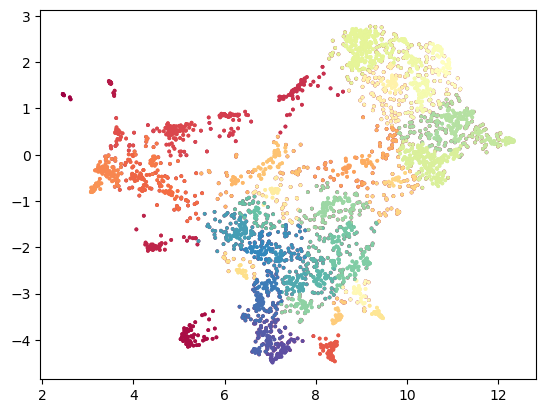

In [14]:
# Create an HDBSCAN instance with custom parameters
# cluster based on UMAP
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=10, metric='euclidean')
clusterer.fit(umap_embeddings)
# cluster based on high dimensional data (embeddings)
# from sklearn.metrics import pairwise_distances
# cosine_similarity = pairwise_distances(embeddings, metric='cosine')
# cosine_distance = 1 - cosine_similarity
# clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=10, metric='precomputed')
# clusterer.fit_predict(cosine_distance)


cluster_labels = clusterer.labels_
np.unique(cluster_labels)
# plot embedding with cluster labels
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, s=3, cmap='Spectral')
# Find the centroids of the non-noise clusters
unique_labels = np.unique(cluster_labels)
non_noise_labels = unique_labels[unique_labels != -1]
centroids = [umap_embeddings[cluster_labels == label].mean(axis=0) for label in non_noise_labels]
from scipy.spatial.distance import cdist
# Assign noise points to the closest cluster centroid
noise_points = umap_embeddings[cluster_labels == -1]
closest_centroid_indices = np.argmin(cdist(noise_points, centroids), axis=1)

# Update cluster_labels with the new assignments for noise points
noise_indices = np.where(cluster_labels == -1)[0]
new_assignments = [non_noise_labels[index] for index in closest_centroid_indices]
cluster_labels[noise_indices] = new_assignments
# plot embedding with cluster labels
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, s=3, cmap='Spectral')
# write clusterer.labels_ to a csv file


In [15]:
np.savetxt("../data/akhaliq_tweets-hdbscan.csv", clusterer.labels_, delimiter=",", header="cluster", comments="")


In [ ]:
# select all of the blog entries in the same order as the blog_entry_embeddings table
# data = data[["id", "text"]].copy()
# data.shape

In [16]:

# add the cluster labels to the dataframe
data['cluster'] = clusterer.labels_
# add x and y as columns to the dataframe from the embedding
data['x'] = umap_embeddings[:, 0]
data['y'] = umap_embeddings[:, 1]
data.head()
# write the dataframe to a csv file
data.to_csv("../data/akhaliq_tweets-processed.csv", index=False)


In [17]:
# group by cluster and concat the titles
cluster_extract = data.groupby('cluster')['Text'].apply(lambda x: '\n*'.join(x)).reset_index()
# rename the title column of cluster_titles to summary
cluster_extract.rename(columns={'Text': 'extract'}, inplace=True)
# save the cluster titles to a csv file
cluster_extract.to_csv('../data/akhaliq_tweets-cluster-extract.csv', index=False)